In [ ]:
# this code is generated by the Domino Code Assist toolbar button
import domino_code_assist as dca
dca.init()

# Imports and Configs

In [ ]:
pip install tensorflow --user

In [63]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import seaborn as sns
# import torch.nn as nn
# import torch.nn.functional as F
# import torch   

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
# from torchvision.transforms import transforms
# from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout2d, BatchNorm2d
# from torchvision.datasets import ImageFolder
# from torch.utils.data import WeightedRandomSampler
# from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import layers



In [64]:
class Config: 
    img_dimensions = (128, 128)
    cls_num = 24
    channels = 3 # number of channels in each image (RGB)
    images_path = '/domino/datasets/UPRM_Hackathon_2023'

# Data Exploration

In [65]:
train_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/train_data_uprm.csv') # read in training data
val_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/val_data_uprm.csv') # read in validation data
test_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/test_data_uprm.csv') # read in testing data.  

In [66]:
train_data_raw

,image,label
0,0073MR0003940000103660E01_DRCL.JPG,17
1,0566MH0002640000201869E01_DRCL.JPG,23
2,0019MR0000540470100217I01_DRCL.JPG,8
3,0019MR0000590050100159C00_DRCL.JPG,8
4,0374MH0003050000104269I01_DRCL.JPG,9
...,...,...
3625,0153MR0008470140201256I01_DRCL.JPG,8
3626,0270MH0002530050102766I01_DRCL.JPG,5
3627,0286ML0012180000106292I01_DRCL.JPG,10
3628,0032ML0000820000100869E01_DRCL.JPG,22


In [67]:
val_data_raw

,image,label
0,0065ML0003320000102432I01_DRCL.JPG,22
1,0077MR0005750500103825E01_DRCL.JPG,8
2,0019ML0000540860100367I01_DRCL.JPG,8
3,0735ML0031510010205284I01_DRCL.JPG,23
4,0055MR0002530020103074E01_DRCL.JPG,8
...,...,...
1551,0017ML0000510070100254C00_DRCL.JPG,8
1552,0078MR0005760430103878E01_DRCL.JPG,8
1553,0050ML0002300290102177E01_DRCL.JPG,8
1554,0003ML0000000490100069E01_DRCL.JPG,8


In [68]:
test_data_raw

,image,label
0,0581MR0024160000400280E01_DRCL.JPG,0
1,0894MR0038960000501235E01_DRCL.JPG,0
2,0954MR0042020000502170I01_DRCL.JPG,0
3,0611MR0025740000401044I01_DRCL.JPG,0
4,1048MR0046080000104543E01_DRCL.JPG,0
...,...,...
1500,0463MH0002640010200205I01_DRCL.JPG,23
1501,0513MH0002590000200936E01_DRCL.JPG,23
1502,0537MH0002590000201384I01_DRCL.JPG,23
1503,0561MH0002590000201757E01_DRCL.JPG,23


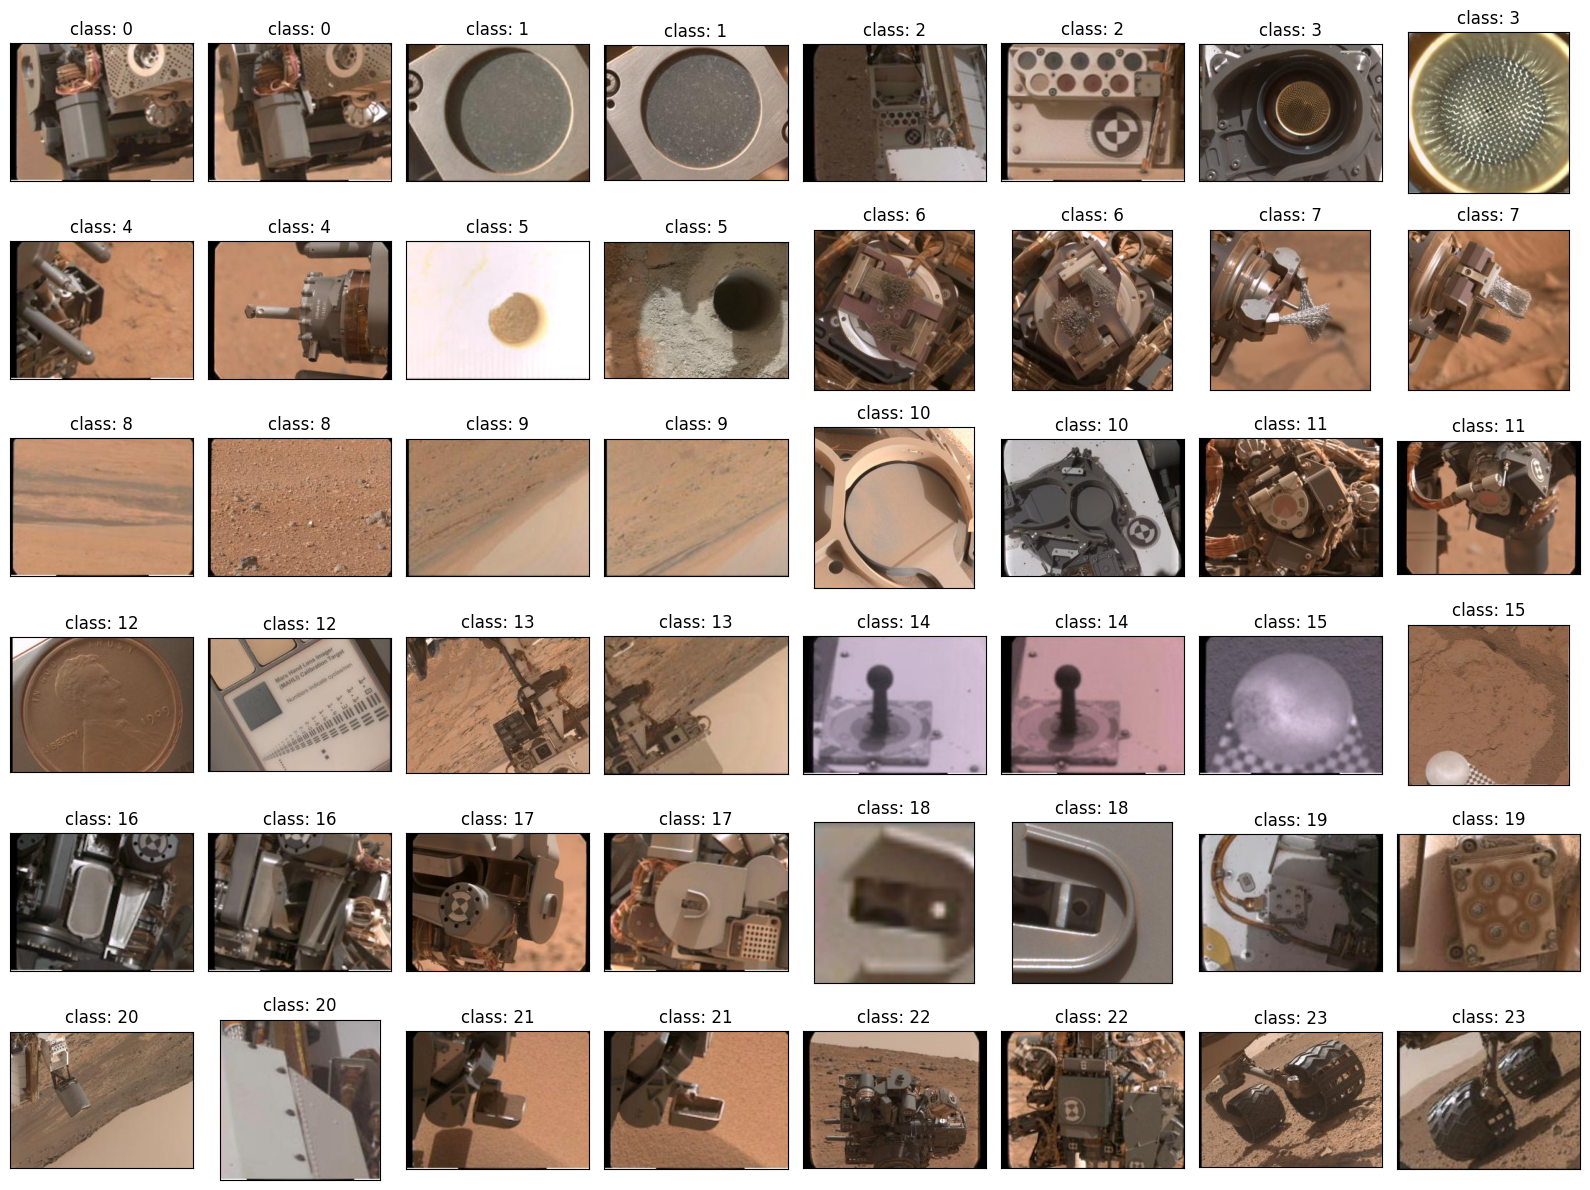

In [115]:
train_images = [os.path.join(Config.images_path, i) for i in train_data_raw['image']]
train_labels = [i for i in train_data_raw['label']]

val_images = [os.path.join(Config.images_path, i) for i in val_data_raw['image']]
val_labels = [i for i in val_data_raw['label']]

test_images = [os.path.join(Config.images_path, i) for i in test_data_raw['image']]
test_labels = [i for i in test_data_raw['label']]

def img_display(ax, path, label):
    read_image = cv2.imread(path)[:,:,::-1]
    ax.imshow(read_image)
    ax.grid(False)
    ax.set_title(f'class: {label}')
    ax.set_xticks([]) 
    ax.set_yticks([]) 

class_counters = {cls: 0 for cls in range(24)}
fig, axes = plt.subplots(6, 8, figsize=(16, 12))
axes = axes.flatten()

ax_idx = 0
# Class loop
for cls in range(24):
    for j in range(len(train_images)):
        if train_labels[j] == cls:
            if class_counters[cls] < 2:
                img_display(axes[ax_idx], train_images[j], train_labels[j])
                class_counters[cls] += 1
                ax_idx += 1
    if all(count == 2 for count in class_counters.values()):
        break

plt.tight_layout()
plt.show()

# Data Augmentation

In [72]:
train_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/train_data_uprm.csv') # read in training data
val_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/val_data_uprm.csv') # read in validation data
test_data_raw = pd.read_csv('/domino/datasets/UPRM_Hackathon_2023/test_data_uprm.csv') # read in testing data.  

We look at the distribution of classes

<Axes: >

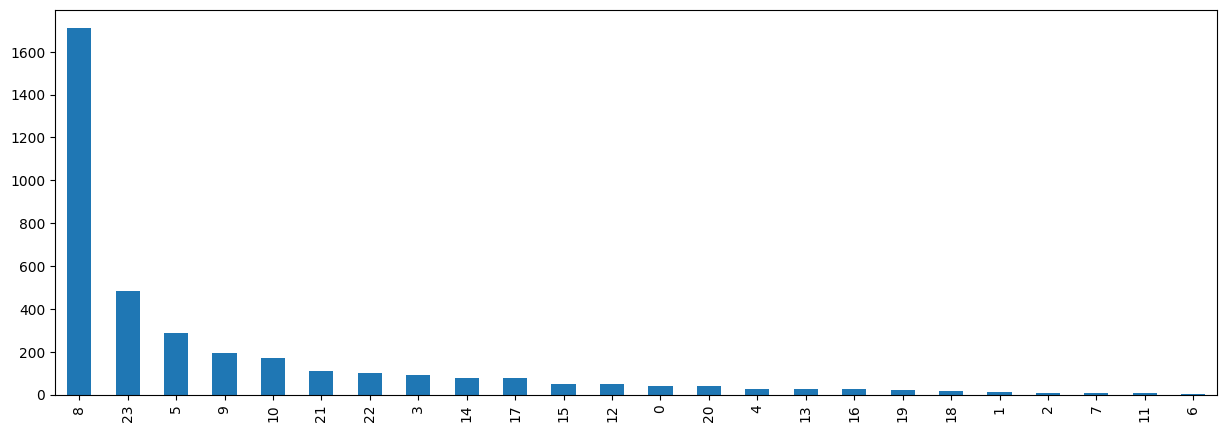

In [73]:
figure = plt.figure(figsize=(15,5))
train_data_raw['label'].value_counts().plot(kind='bar')

Oversampling underrepresented classes

In [74]:
majority_cls = train_data_raw['label'].value_counts().idxmax()
# target_count = train_data_raw['label'].value_counts().max()
target_count = 700

oversampled_data = pd.DataFrame(columns=train_data_raw.columns)

for cls in train_data_raw['label'].unique():
    if train_data_raw[train_data_raw['label']==cls].shape[0] <= 300:
        class_df = train_data_raw[train_data_raw['label'] == cls]
        num_samples = len(class_df)
        oversampling = int(target_count / num_samples)
        oversampled_data = pd.concat([oversampled_data] + [class_df] * oversampling, ignore_index=True)
    else:
        class_df = train_data_raw[train_data_raw['label'] == cls]
        oversampled_data = pd.concat([oversampled_data] + [class_df], ignore_index=True)
        
        
    # print("Class: {}, Oversampling factor: {}".format(cls, oversampling))
        
# print(majority_cls)
# print(target_count)

<Axes: >

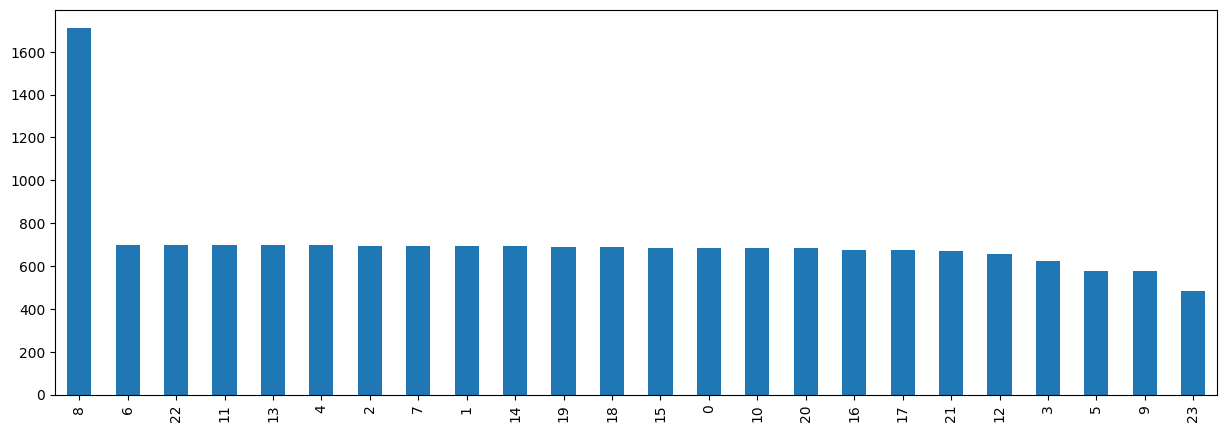

In [75]:
figure = plt.figure(figsize=(15,5))
oversampled_data['label'].value_counts().plot(kind='bar')

We choose `data_pt_per_cls` datapoints per class for all the classes so that they are all equally represented. To avoid biasing the final training dataset, we shuffle the data and *then* apply the cut.

In [76]:
train_data = pd.DataFrame(columns=train_data_raw.columns)

data_pt_per_cls = 300

for cls in oversampled_data['label'].unique():
    class_df = oversampled_data[oversampled_data['label'] == cls]
    class_df = class_df.sample(frac=1.0, random_state=42)[:data_pt_per_cls]
    train_data = pd.concat([train_data] + [class_df], ignore_index=True)

<Axes: >

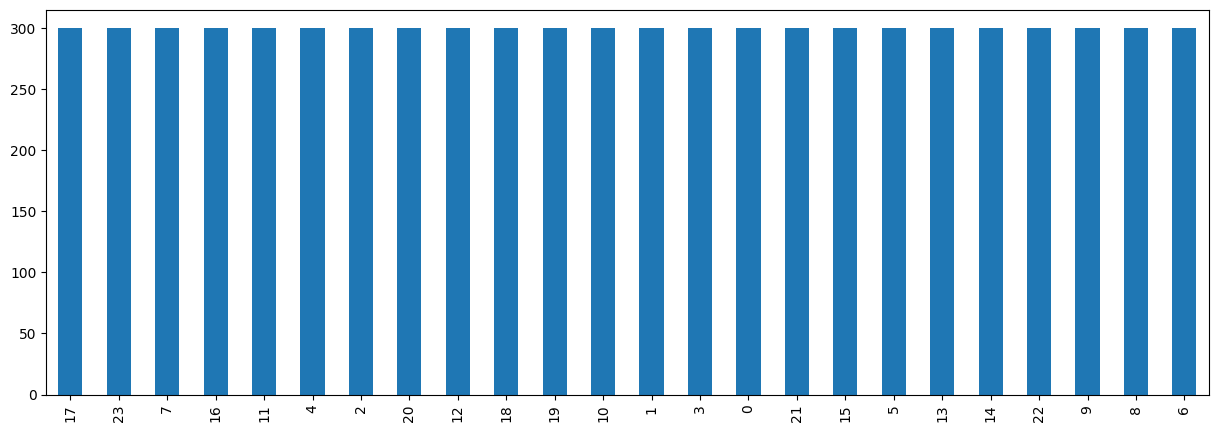

In [77]:
figure = plt.figure(figsize=(15,5))
train_data['label'].value_counts().plot(kind='bar')

Type conversion needed to feed into Keras data generator

In [78]:
train_data = train_data.convert_dtypes()
val_data_raw = val_data_raw.convert_dtypes()

train_data['label'] = train_data['label'].apply(lambda x: [x])
val_data_raw ['label'] = val_data_raw['label'].apply(lambda x: [x])

Creating the training and validation data generators

In [79]:
# training data gen
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                                    x_col = "image",
                                                    y_col = "label",
                                                    target_size=Config.img_dimensions,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    directory='/domino/datasets/UPRM_Hackathon_2023')

# validation data gen
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe=val_data_raw, 
                                                x_col = "image",
                                                y_col = "label",
                                                target_size=Config.img_dimensions,
                                                batch_size=32,
                                                class_mode='categorical',
                                                directory='/domino/datasets/UPRM_Hackathon_2023')

Found 7193 validated image filenames belonging to 24 classes.


/home/ubuntu/.local/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 7 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 1555 validated image filenames belonging to 24 classes.


/home/ubuntu/.local/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


# Model Building & Training
We apply transfer learning to minimize training time and maximize model performance

In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file= '/mnt/ItDepends/ItDepends_folder/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (128, 128, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [81]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


Adding last layers to the transferred model

In [82]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(24, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

Defining a model checkpoint callback which saves the model weights to maximize validation loss.

In [83]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/mnt/ItDepends/ItDepends_folder/model.hdf5',
    monitor = 'val_loss',
    mode='min',
    save_best_only=True)

We can now compile the final model structure. We track accuracy, AUC and f1 score, and we use the Adadelta optimizer with an initial learning rate of 1 and a categorical cross entropy loss.

In [84]:
from keras import backend as K

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [38]:
model.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=24, from_logits=False),
              f1_score])

And now we train!

In [40]:
history = model.fit(
    x=train_generator,  
    epochs=10,
    validation_data=val_generator,  
    verbose=2,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
225/225 - 97s - loss: 0.0683 - accuracy: 0.9766 - auc_1: 0.9992 - f1_score: 0.9765 - val_loss: 0.1216 - val_accuracy: 0.9608 - val_auc_1: 0.9991 - val_f1_score: 0.9620 - 97s/epoch - 431ms/step
Epoch 2/10
225/225 - 97s - loss: 0.0662 - accuracy: 0.9794 - auc_1: 0.9989 - f1_score: 0.9795 - val_loss: 0.1172 - val_accuracy: 0.9653 - val_auc_1: 0.9986 - val_f1_score: 0.9652 - 97s/epoch - 432ms/step
Epoch 3/10
225/225 - 98s - loss: 0.0655 - accuracy: 0.9783 - auc_1: 0.9991 - f1_score: 0.9786 - val_loss: 0.0909 - val_accuracy: 0.9717 - val_auc_1: 0.9988 - val_f1_score: 0.9718 - 98s/epoch - 434ms/step
Epoch 4/10
225/225 - 100s - loss: 0.0576 - accuracy: 0.9791 - auc_1: 0.9993 - f1_score: 0.9800 - val_loss: 0.0825 - val_accuracy: 0.9717 - val_auc_1: 0.9988 - val_f1_score: 0.9718 - 100s/epoch - 443ms/step
Epoch 5/10
225/225 - 99s - loss: 0.0607 - accuracy: 0.9815 - auc_1: 0.9990 - f1_score: 0.9819 - val_loss: 0.0718 - val_accuracy: 0.9833 - val_auc_1: 0.9985 - val_f1_score: 0.9828 - 9

In [41]:
# In case the model will be saved manually instead of through the model checkpoint callback.
# model.save("itdepends_model.hdf5") 
# model.save_weights("itdepends_weights.hdf5")

Plotting the training and validating accuracy and loss

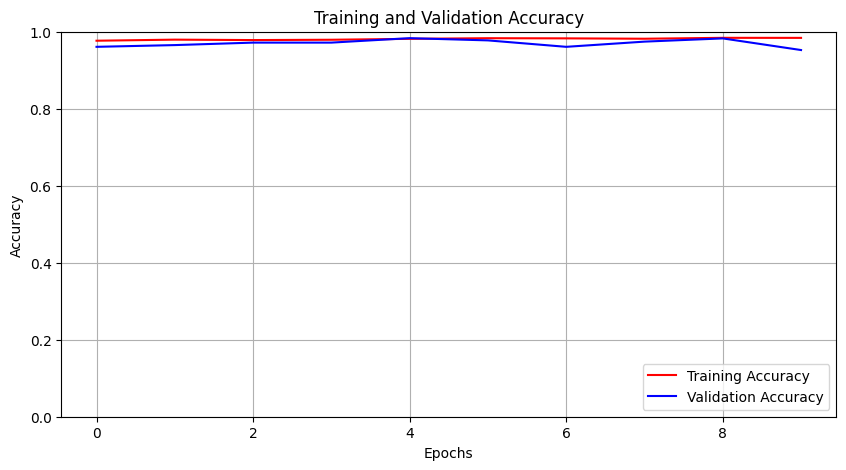

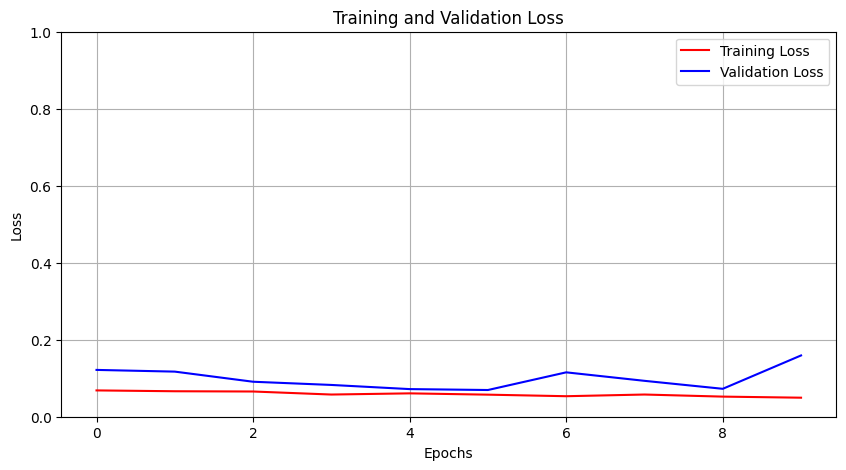

In [92]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.ylim(0, 1)  # Adjust y-axis limit based on data
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Model Testing
Now we show the trained model data it hasn't seen before. From this we construct a confusion matrix to get a better idea of how it performs.

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score as f1_sk

In [94]:
# Same data type conversion done before, but this time for test data
test_data_raw = test_data_raw.convert_dtypes()
test_data_raw ['label'] = test_data_raw['label'].apply(lambda x: [x])

In [95]:
# test data gen
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_data_raw, 
                                                x_col = "image",
                                                y_col = "label",
                                                target_size=Config.img_dimensions,
                                                # batch_size=32,
                                                class_mode='categorical',
                                                directory='/domino/datasets/UPRM_Hackathon_2023',
                                                shuffle=False)

Found 1505 validated image filenames belonging to 24 classes.


In [ ]:
# Pre-test of model as a sanity check
# model.evaluate(test_generator)

Putting test data through our trained model...

In [50]:
test_predict = model.predict(test_generator)

48/48 [==============================] - 8s 151ms/step


In [51]:
test_predict = np.argmax(test_predict, axis=1)
cm = confusion_matrix(np.ravel(test_data_raw['label'].to_list()), test_predict)
disp = ConfusionMatrixDisplay(cm)

Generating the confusion matrix

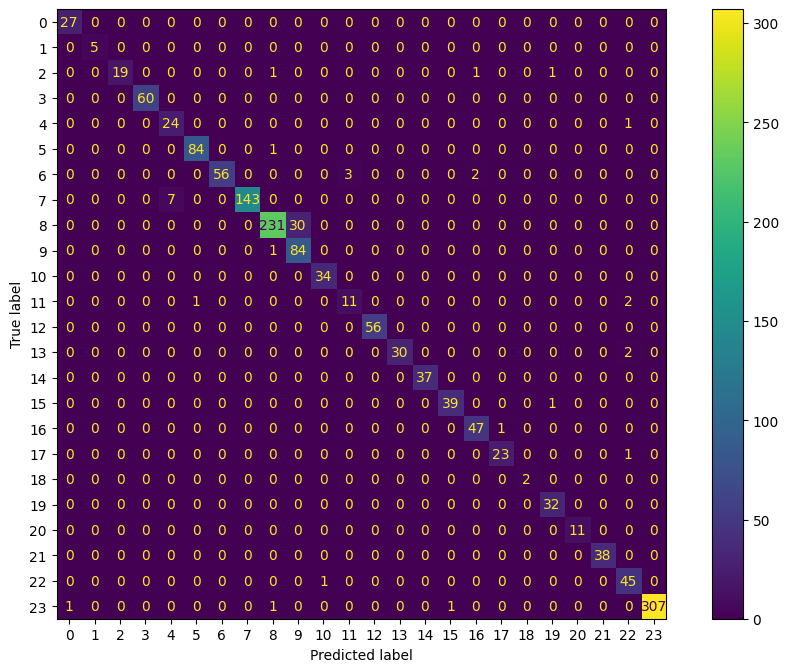

In [54]:
figure,ax = plt.subplots(dpi=99,figsize=(12,8))

disp.plot(ax=ax)
figure.savefig('cm.pdf')
plt.show()

In [55]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [61]:
# cm = confusion_matrix(np.ravel(test_data_raw['label'].to_list()), test_predict)
F1_score = f1_sk(np.ravel(test_data_raw['label'].to_list()), test_predict, average='macro')

print(f'f1_score: {F1_score}')
print(f"{bcolors.FAIL}{bcolors.BOLD}{bcolors.UNDERLINE}Recall: Criteria for winning submissions is determined by the F1 score above!")

f1_score: 0.9578009479615192
Recall: Criteria for winning submissions is determined by the F1 score above!


# Credit
This notebook was the winning submission of Lockheed Martin's AI & Machine Learning Technologies Hackathon. ItDepends team was composed by:
- Roy F. Cruz
- Tetiana Mazurets
- Guillermo Fidalgo

Thanks to my teammates for making the experience so much fun! And thanks to the organizers for such a great learning experience. 